# percent-allocate

Maintain a percent allocation of a security in account  
(1) If bull regime, set target share of 70%.  Allow range of 65% to 75%.  Check daily.  
(2) If bear regime, close out position

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data
pd.options.display.float_format = '{:0.2f}'.format
pd.set_option('display.max_rows', None)

%matplotlib inline

In [2]:
# Set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

Define target_percent and band

In [4]:
options = {
    'use_adj' : True,
    'use_cache' : True,
    'target_percent' : 70/100,
    'band' : 5/100
}

Define Strategy Class 

In [5]:
class Strategy:

    def __init__(self, symbol, capital, start, end, options):

        self.symbol = symbol
        self.capital = capital
        self.start = start
        self.end = end
        self.options = options
        
        self.ts = None
        self.rlog = None
        self.tlog = None
        self.dbal = None
        self.stats = None

    def _algo(self):
        pf.TradeLog.cash = self.capital

        for i, row in enumerate(self.ts.itertuples()):

            date = row.Index.to_pydatetime()
            close = row.close; 
            end_flag = pf.is_last_row(self.ts, i)
            
            share_percent = self.tlog.share_percent(close)
            target_percent = self.options['target_percent'] 
            upper_band = target_percent + self.options['band']
            lower_band = target_percent - self.options['band']
            
            # Close Out Logic
            # First we check if an existing position in symbol should be sold
            #  - sell if regime < 0 or end of data

            if (self.tlog.shares > 0
                and (row.regime < 0 or end_flag)):
                # close position
                self.tlog.adjust_percent(date, close, 0)

            # Adjust Shares Logic
            #  - Adjust Shares if regime > 0
            #            and share percent outside of target_percent band
            #            and (use_regime_filter and regime > 0)
            
            else:
                if (row.regime > 0
                    and not lower_band < share_percent < upper_band):
                    # adjust shares to target_percent
                    self.tlog.adjust_percent(date, close, target_percent)   

            # record daily balance
            self.dbal.append(date, close)

    def run(self):
        
        # Fetch and select timeseries
        self.ts = pf.fetch_timeseries(self.symbol, use_cache=self.options['use_cache'])
        self.ts = pf.select_tradeperiod(self.ts, self.start, self.end, use_adj=self.options['use_adj'])

        # Add technical indicator: 200 sma regime filter plus 3% band
        self.ts['regime'] = \
            pf.CROSSOVER(self.ts, timeperiod_fast=1, timeperiod_slow=200, band=3.0)
        
        # Finalize timeseries
        self.ts, self.start = pf.finalize_timeseries(self.ts, self.start,
                                                     dropna=True, drop_columns=['open', 'high', 'low'])

        self.tlog = pf.TradeLog(self.symbol)
        self.dbal = pf.DailyBal()

        self._algo()
        self._get_logs()
        self._get_stats()
        
    def _get_logs(self):
        self.rlog = self.tlog.get_log_raw()
        self.tlog = self.tlog.get_log()
        self.dbal = self.dbal.get_log(self.tlog)

    def _get_stats(self):
        self.stats = pf.stats(self.ts, self.tlog, self.dbal, self.capital)

Run Strategy

In [6]:
s = Strategy(symbol, capital, start, end, options)
s.run()

View logs

In [7]:
s.rlog.tail()

,date,seq_num,price,shares,entry_exit,direction,symbol
34,2022-02-23,34,412.10,112,exit,LONG,SPY
35,2022-03-29,35,452.18,100,entry,LONG,SPY
36,2022-04-22,36,417.39,100,exit,LONG,SPY
37,2023-01-26,37,401.72,107,entry,LONG,SPY
38,2023-07-06,38,439.66,107,exit,LONG,SPY


In [8]:
s.tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
19,2019-03-15,262.37,2020-03-09,259.46,-2.90,-397.71,137,41025.02,LONG,SPY
20,2020-06-02,293.20,2021-04-01,387.38,94.18,847.59,9,41872.61,LONG,SPY
21,2020-06-02,293.20,2022-02-23,412.10,118.90,13316.86,112,55189.47,LONG,SPY
22,2022-03-29,452.18,2022-04-22,417.39,-34.79,-3478.91,100,51710.56,LONG,SPY
23,2023-01-26,401.72,2023-07-06,439.66,37.94,4059.70,107,55770.26,LONG,SPY


In [9]:
s.dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2023-06-29,65604.40,65604.40,65604.40,107,18726.64,1.00,-
2023-06-30,66157.60,66157.60,66157.60,107,18726.64,1.00,-
2023-07-03,66212.17,66212.17,66212.17,107,18726.64,1.00,-
2023-07-05,66141.55,66141.55,66141.55,107,18726.64,1.00,-
2023-07-06,65770.26,65770.26,65770.26,0,65770.26,1.00,X


Run Benchmark

In [10]:
benchmark = pf.Benchmark(symbol, s.capital, s.start, s.end)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

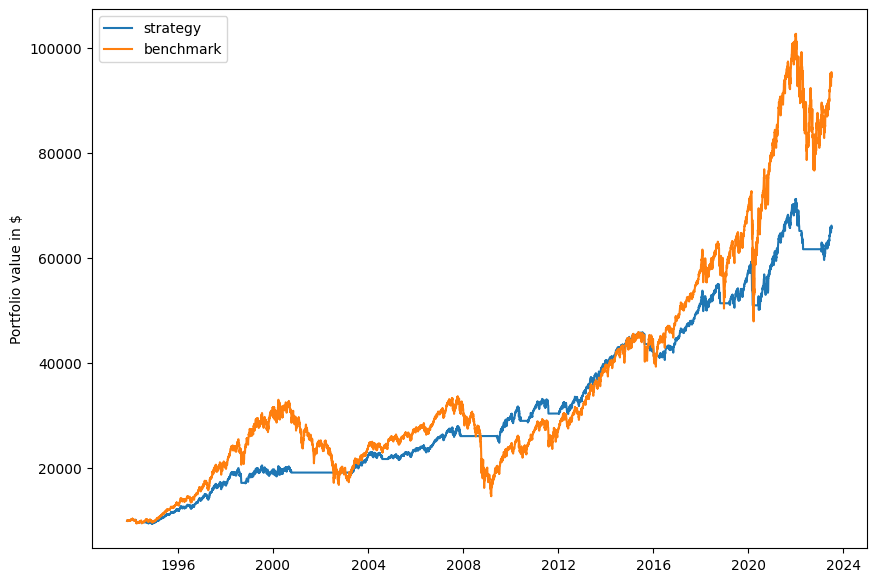

In [11]:
pf.plot_equity_curve(s.dbal, benchmark=benchmark.dbal)

Plot Trades

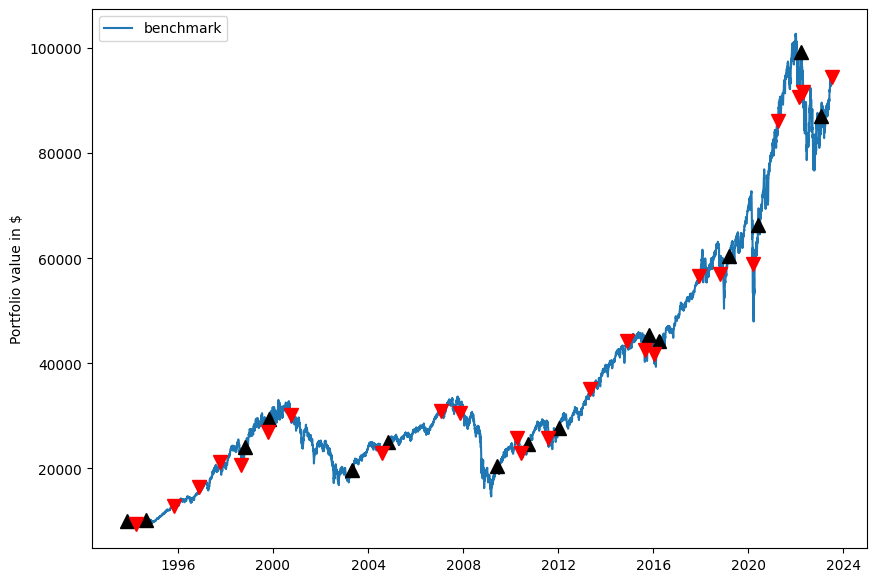

In [12]:
pf.plot_trades(s.dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,6.56,7.87
max_closed_out_drawdown,-16.32,-56.42
annualized_return_over_max_drawdown,0.40,0.14
best_month,10.69,23.06
worst_month,-14.01,-31.38
sharpe_ratio,0.76,0.49
sortino_ratio,0.84,0.63
monthly_std,2.26,4.54
annual_std,8.96,16.97


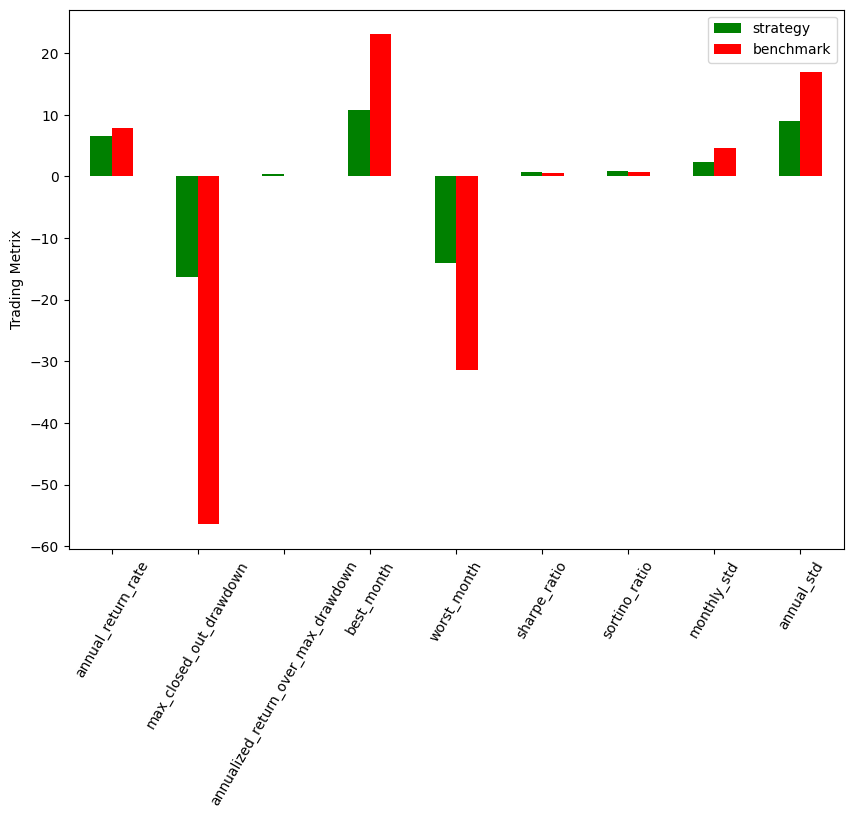

In [13]:
df = pf.plot_bar_graph(s.stats, benchmark.stats)
df

Total Number of Trades

In [14]:
s.stats.total_num_trades

24